In [1]:
# Install necessary libraries
%pip install transformers accelerate bitsandbytes scipy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 12.8 MB/s eta 0:00:00


In [2]:
import requests
from PIL import Image
import torch
from transformers import Mask2FormerForUniversalSegmentation, Mask2FormerImageProcessor
import matplotlib.pyplot as plt
import numpy as np

In [14]:
# Load the Mask2Former model and processor
processor = Mask2FormerImageProcessor.from_pretrained("ravinduwe/mask2former-swin-large-ade-semantic-enhanced")
model = Mask2FormerForUniversalSegmentation.from_pretrained("ravinduwe/mask2former-swin-large-ade-semantic-enhanced")

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/transformers/image_processing_base.py:410: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.__init__` and were ignored: '_max_size', 'reduce_labels'
  image_processor = cls(**image_processor_dict)


In [8]:
%pip install datasets

In [9]:
from datasets import load_dataset

ade20k_dataset = load_dataset("1aurent/ADE20K", split="validation")

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00010.parquet:   0%|          | 0.00/436M [00:00<?, ?B/s]

data/train-00001-of-00010.parquet:   0%|          | 0.00/478M [00:00<?, ?B/s]

data/train-00002-of-00010.parquet:   0%|          | 0.00/488M [00:00<?, ?B/s]

data/train-00003-of-00010.parquet:   0%|          | 0.00/293M [00:00<?, ?B/s]

data/train-00004-of-00010.parquet:   0%|          | 0.00/441M [00:00<?, ?B/s]

data/train-00005-of-00010.parquet:   0%|          | 0.00/679M [00:00<?, ?B/s]

data/train-00006-of-00010.parquet:   0%|          | 0.00/299M [00:00<?, ?B/s]

data/train-00007-of-00010.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

data/train-00008-of-00010.parquet:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

data/train-00009-of-00010.parquet:   0%|          | 0.00/555M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/474M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25574 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [21]:
import random

random_indices = random.sample(range(len(ade20k_dataset)), 4)
images = [ade20k_dataset[i]['image'] for i in random_indices]

In [22]:
inputs = processor(images=images, return_tensors="pt")

In [23]:
# Perform segmentation
with torch.no_grad():
    outputs = model(**inputs)

# Post-process the outputs
# Assuming semantic segmentation for simplicity. Adjust for panoptic or instance if needed.
segmentation_maps = processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1] for image in images])

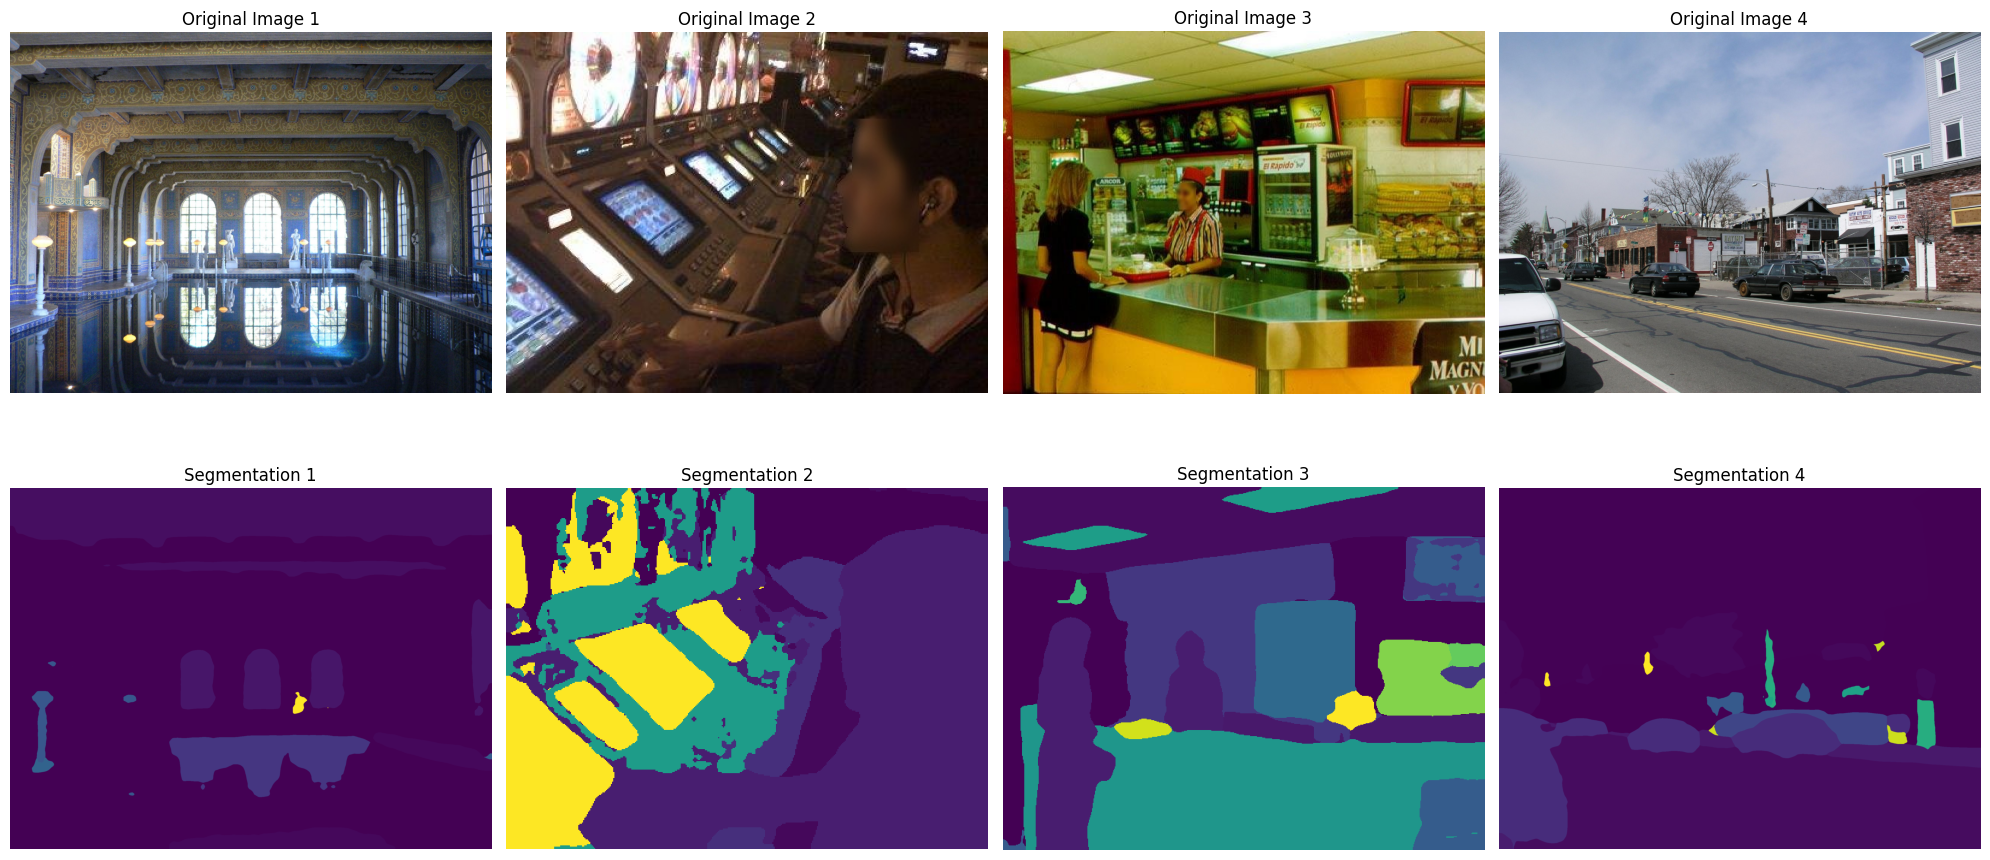

In [31]:
# Display the results in a 2x4 grid
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for i, (image, segmentation_map) in enumerate(zip(images, segmentation_maps)):
    # Display original image in the top row
    axes[0, i].imshow(image)
    axes[0, i].set_title(f"Original Image {i+1}")
    axes[0, i].axis('off')

    # Display segmentation map in the bottom row
    axes[1, i].imshow(segmentation_map.cpu().numpy()) # Display segmentation without alpha for clarity
    axes[1, i].set_title(f"Segmentation {i+1}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

In [18]:
import requests
import torch
from PIL import Image
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation


# load Mask2Former fine-tuned on ADE20k semantic segmentation
processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-large-ade-semantic")
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-large-ade-semantic")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
inputs = processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

# model predicts class_queries_logits of shape `(batch_size, num_queries)`
# and masks_queries_logits of shape `(batch_size, num_queries, height, width)`
class_queries_logits = outputs.class_queries_logits
masks_queries_logits = outputs.masks_queries_logits

# you can pass them to processor for postprocessing
predicted_semantic_map = processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
# we refer to the demo notebooks for visualization (see "Resources" section in the Mask2Former docs)


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [19]:
predicted_semantic_map.shape

torch.Size([480, 640])

In [ ]:
# Display the results in a 1x4 grid
fig, axes = plt.subplots(2, 1, figsize=(20, 5))

for i, (image, segmentation_map) in enumerate(zip(images, segmentation_maps)):
    axes[i].imshow(image)
    axes[i].imshow(segmentation_map.cpu().numpy(), alpha=0.5) # Overlay segmentation
    axes[i].set_title(f"Image {i+1}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()